In [28]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import collections
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [29]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(2,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,3) #Cart를 왼쪽, 오른쪽 또는 그대로 있는다. output 3개
     
    #nforward 방향 network 구성
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #액션에 대한 Q 값
        return x
    
    def sample_action(self, obs, epsilon): #option 함수인데, 액션을 고르는 Function 
        out = self.forward(obs) #state 를 NN 에 입력
        rv = random.random() #epsilon Greedy 를 하고 있어서, Random value 생성
        
        if rv<epsilon:
            return random.randint(0,2) #0, 1, 2 액션 중에 random 하게 return
        else:
            return out.argmax().item() # Q 값이 큰 액션을 return


In [30]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=50000) #deque 를 이용해서 replaybuffer 생성
    
    def size(self):
        return len(self.buffer)
    
    def put(self, transition):
        self.buffer.append(transition) #buffer에 넣는다
        
    def sample(self,n):
        mini_batch = random.sample(self.buffer,n) #buffer에서 n 개의 sample 을 꺼내온다
        
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [],[],[],[],[]  #transition 의 s, a, r 끼리 리스트 만들기
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)  #s는 벡터
            a_lst.append([a]) #a는 상수값
            r_lst.append([r]) #r도 상수값
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
     
        #tensor 형태로 바꿔서 전달
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)
    
            

In [31]:
def train(q, q_target, memory, optimizer):
    
    for i in range(15):
        s, a, r, s_prime, done_mask = memory.sample(32) #32개 호출
        
        q_out = q(s) #q는 main에서 DQN, DQN을 호출하면 Forward를 호출하도록 torch.nn.Moduel에서 정의되어 있음
        q_a = q_out.gather(1,a) #32개의 action vector            
        
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        #gamma=0.05
        target = r + 0.05*max_q_prime * done_mask
        
        #loss = F.mse_loss(q_a, target)
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

Episode :1, Score : 1620.0, Buffer : 400, Epsilon : 8.0%, Success_count : 0
Episode :2, Score : 730.0, Buffer : 600, Epsilon : 8.0%, Success_count : 0
Episode :3, Score : 710.0, Buffer : 800, Epsilon : 8.0%, Success_count : 0
Episode :4, Score : 650.0, Buffer : 1000, Epsilon : 8.0%, Success_count : 0
Episode :5, Score : 730.0, Buffer : 1200, Epsilon : 8.0%, Success_count : 0
Episode :6, Score : 630.0, Buffer : 1400, Epsilon : 8.0%, Success_count : 0
Episode :7, Score : 610.0, Buffer : 1600, Epsilon : 8.0%, Success_count : 0
Episode :8, Score : 630.0, Buffer : 1800, Epsilon : 8.0%, Success_count : 0
Episode :9, Score : 710.0, Buffer : 2000, Epsilon : 8.0%, Success_count : 0
Episode :10, Score : 610.0, Buffer : 2200, Epsilon : 8.0%, Success_count : 0
Episode :11, Score : 900.0, Buffer : 2400, Epsilon : 7.9%, Success_count : 0
Episode :12, Score : 860.0, Buffer : 2600, Epsilon : 7.9%, Success_count : 0
Episode :13, Score : 990.0, Buffer : 2800, Epsilon : 7.9%, Success_count : 0
Episode :1

Episode :109, Score : 740.0, Buffer : 22000, Epsilon : 7.5%, Success_count : 0
Episode :110, Score : 940.0, Buffer : 22200, Epsilon : 7.4%, Success_count : 0
Episode :111, Score : 730.0, Buffer : 22400, Epsilon : 7.4%, Success_count : 0
Episode :112, Score : 1010.0, Buffer : 22600, Epsilon : 7.4%, Success_count : 0
Episode :113, Score : 660.0, Buffer : 22800, Epsilon : 7.4%, Success_count : 0
Episode :114, Score : 870.0, Buffer : 23000, Epsilon : 7.4%, Success_count : 0
Episode :115, Score : 750.0, Buffer : 23200, Epsilon : 7.4%, Success_count : 0
Episode :116, Score : 860.0, Buffer : 23400, Epsilon : 7.4%, Success_count : 0
Episode :117, Score : 720.0, Buffer : 23600, Epsilon : 7.4%, Success_count : 0
Episode :118, Score : 9550.0, Buffer : 23800, Epsilon : 7.4%, Success_count : 44
Episode :119, Score : 7830.0, Buffer : 24000, Epsilon : 7.4%, Success_count : 35
Episode :120, Score : 870.0, Buffer : 24200, Epsilon : 7.4%, Success_count : 0
Episode :121, Score : 640.0, Buffer : 24400, Ep

Episode :212, Score : 910.0, Buffer : 42600, Epsilon : 6.9%, Success_count : 0
Episode :213, Score : 10240.0, Buffer : 42800, Epsilon : 6.9%, Success_count : 48
Episode :214, Score : 10510.0, Buffer : 43000, Epsilon : 6.9%, Success_count : 49
Episode :215, Score : 7120.0, Buffer : 43200, Epsilon : 6.9%, Success_count : 32
Episode :216, Score : 5170.0, Buffer : 43400, Epsilon : 6.9%, Success_count : 22
Episode :217, Score : 940.0, Buffer : 43600, Epsilon : 6.9%, Success_count : 0
Episode :218, Score : 4960.0, Buffer : 43800, Epsilon : 6.9%, Success_count : 21
Episode :219, Score : 990.0, Buffer : 44000, Epsilon : 6.9%, Success_count : 0
Episode :220, Score : 880.0, Buffer : 44200, Epsilon : 6.9%, Success_count : 0
Episode :221, Score : 22830.0, Buffer : 44400, Epsilon : 6.9%, Success_count : 112
Episode :222, Score : 900.0, Buffer : 44600, Epsilon : 6.9%, Success_count : 0
Episode :223, Score : 11590.0, Buffer : 44800, Epsilon : 6.9%, Success_count : 55
Episode :224, Score : 1000.0, Buf

Episode :314, Score : 920.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 0
Episode :315, Score : 8280.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 38
Episode :316, Score : 5740.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 25
Episode :317, Score : 4990.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 21
Episode :318, Score : 7470.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 34
Episode :319, Score : 7800.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 35
Episode :320, Score : 9020.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 42
Episode :321, Score : 970.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 0
Episode :322, Score : 7140.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 32
Episode :323, Score : 8360.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 38
Episode :324, Score : 8310.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 38
Episode :325, Score : 990.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 0
Episode :326, Score : 1030.0, Buff

Episode :416, Score : 9260.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 43
Episode :417, Score : 7960.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 36
Episode :418, Score : 9450.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 44
Episode :419, Score : 7690.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 35
Episode :420, Score : 3460.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 13
Episode :421, Score : 11040.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 52
Episode :422, Score : 9860.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 46
Episode :423, Score : 8850.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 41
Episode :424, Score : 6500.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 29
Episode :425, Score : 6170.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 27
Episode :426, Score : 7300.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 33
Episode :427, Score : 890.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 0
Episode :428, Score : 9120.0,

Episode :518, Score : 8670.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 40
Episode :519, Score : 8570.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 39
Episode :520, Score : 5140.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 22
Episode :521, Score : 8930.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 41
Episode :522, Score : 9260.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 43
Episode :523, Score : 6140.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 27
Episode :524, Score : 990.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 0
Episode :525, Score : 7950.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 36
Episode :526, Score : 6890.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 31
Episode :527, Score : 9090.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 42
Episode :528, Score : 3610.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 14
Episode :529, Score : 6120.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 27
Episode :530, Score : 10270.0,

Episode :621, Score : 21680.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 106
Episode :622, Score : 9850.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 46
Episode :623, Score : 900.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 0
Episode :624, Score : 880.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 0
Episode :625, Score : 7490.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 34
Episode :626, Score : 4410.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 18
Episode :627, Score : 7120.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 32
Episode :628, Score : 5770.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 25
Episode :629, Score : 890.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 0
Episode :630, Score : 900.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 0
Episode :631, Score : 9520.0, Buffer : 50000, Epsilon : 4.8%, Success_count : 44
Episode :632, Score : 7330.0, Buffer : 50000, Epsilon : 4.8%, Success_count : 33
Episode :633, Score : 830.0, Buffe

Episode :724, Score : 8910.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 41
Episode :725, Score : 5980.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 26
Episode :726, Score : 7140.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 32
Episode :727, Score : 9270.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 43
Episode :728, Score : 5570.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 24
Episode :729, Score : 6750.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 30
Episode :730, Score : 4000.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 16
Episode :731, Score : 2850.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 10
Episode :732, Score : 6310.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 28
Episode :733, Score : 9850.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 46
Episode :734, Score : 5940.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 26
Episode :735, Score : 8020.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 36
Episode :736, Score : 5970.0

Episode :826, Score : 10270.0, Buffer : 50000, Epsilon : 3.9%, Success_count : 48
Episode :827, Score : 10480.0, Buffer : 50000, Epsilon : 3.9%, Success_count : 49
Episode :828, Score : 10670.0, Buffer : 50000, Epsilon : 3.9%, Success_count : 50
Episode :829, Score : 9320.0, Buffer : 50000, Epsilon : 3.9%, Success_count : 43
Episode :830, Score : 2850.0, Buffer : 50000, Epsilon : 3.9%, Success_count : 10
Episode :831, Score : 7590.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 34
Episode :832, Score : 7950.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 36
Episode :833, Score : 5380.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 23
Episode :834, Score : 9700.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 45
Episode :835, Score : 6740.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 30
Episode :836, Score : 7910.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 36
Episode :837, Score : 910.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 0
Episode :838, Score : 9460.

Episode :928, Score : 880.0, Buffer : 50000, Epsilon : 3.4%, Success_count : 0
Episode :929, Score : 820.0, Buffer : 50000, Epsilon : 3.4%, Success_count : 0
Episode :930, Score : 2990.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 11
Episode :931, Score : 990.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 0
Episode :932, Score : 7730.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 35
Episode :933, Score : 7340.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 33
Episode :934, Score : 6540.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 29
Episode :935, Score : 820.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 0
Episode :936, Score : 5990.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 26
Episode :937, Score : 730.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 0
Episode :938, Score : 6150.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 27
Episode :939, Score : 1000.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 0
Episode :940, Score : 930.0, Buffer : 5

Episode :1031, Score : 8910.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 41
Episode :1032, Score : 900.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1033, Score : 3680.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 14
Episode :1034, Score : 1070.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1035, Score : 960.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1036, Score : 800.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1037, Score : 800.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1038, Score : 6960.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 31
Episode :1039, Score : 1030.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1040, Score : 1020.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1041, Score : 3460.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 13
Episode :1042, Score : 7150.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 32
Episode :1043, Score : 900.

Episode :1133, Score : 1020.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1134, Score : 7190.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 32
Episode :1135, Score : 1030.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1136, Score : 960.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1137, Score : 940.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1138, Score : 850.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1139, Score : 750.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1140, Score : 840.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1141, Score : 1000.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1142, Score : 930.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1143, Score : 970.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1144, Score : 990.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1145, Score : 960.0, Buffe

Episode :1235, Score : 960.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1236, Score : 960.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1237, Score : 920.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1238, Score : 910.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1239, Score : 940.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1240, Score : 10480.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 49
Episode :1241, Score : 850.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1242, Score : 940.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1243, Score : 860.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1244, Score : 2320.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 7
Episode :1245, Score : 4870.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 20
Episode :1246, Score : 1010.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1247, Score : 820.0, Buf

Episode :1337, Score : 940.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1338, Score : 5610.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 24
Episode :1339, Score : 750.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1340, Score : 950.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1341, Score : 980.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1342, Score : 950.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1343, Score : 900.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1344, Score : 800.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1345, Score : 3500.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 13
Episode :1346, Score : 980.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1347, Score : 4310.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 17
Episode :1348, Score : 950.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1349, Score : 840.0, Buff

Episode :1439, Score : 1020.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1440, Score : 740.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1441, Score : 650.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1442, Score : 910.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1443, Score : 6250.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 27
Episode :1444, Score : 4430.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 18
Episode :1445, Score : 900.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1446, Score : 6600.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 29
Episode :1447, Score : 6440.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 28
Episode :1448, Score : 5660.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 24
Episode :1449, Score : 940.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1450, Score : 3090.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 11
Episode :1451, Score : 910.

Episode :1541, Score : 760.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1542, Score : 730.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1543, Score : 930.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1544, Score : 780.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1545, Score : 930.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1546, Score : 830.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1547, Score : 870.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1548, Score : 830.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1549, Score : 5680.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 24
Episode :1550, Score : 990.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1551, Score : 1010.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1552, Score : 960.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1553, Score : 990.0, Buffer 

Episode :1643, Score : 940.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1644, Score : 860.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1645, Score : 820.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1646, Score : 750.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1647, Score : 750.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1648, Score : 900.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1649, Score : 770.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1650, Score : 2750.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 9
Episode :1651, Score : 730.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1652, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1653, Score : 980.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1654, Score : 920.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1655, Score : 5270.0, Buffer :

Episode :1745, Score : 940.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1746, Score : 910.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1747, Score : 9020.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 41
Episode :1748, Score : 1060.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1749, Score : 990.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1750, Score : 860.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1751, Score : 900.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1752, Score : 1000.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1753, Score : 850.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1754, Score : 980.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1755, Score : 970.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1756, Score : 970.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1757, Score : 760.0, Buffer

Episode :1847, Score : 1040.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1848, Score : 940.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1849, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1850, Score : 920.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1851, Score : 760.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1852, Score : 6930.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 31
Episode :1853, Score : 7970.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 36
Episode :1854, Score : 6030.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 26
Episode :1855, Score : 870.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1856, Score : 840.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1857, Score : 1010.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1858, Score : 990.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1859, Score : 940.0, Bu

Episode :1949, Score : 910.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1950, Score : 1000.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1951, Score : 960.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1952, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1953, Score : 960.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1954, Score : 1010.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1955, Score : 980.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1956, Score : 1070.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1957, Score : 7750.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 34
Episode :1958, Score : 840.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1959, Score : 940.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1960, Score : 3910.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 15
Episode :1961, Score : 1070.0, Bu

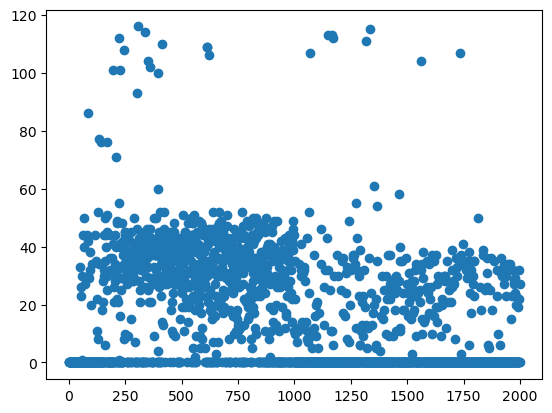

In [36]:
def main():
    #env = gym.make('MountainCar-v0', render_mode="human")
    env = gym.make('MountainCar-v0')
    q = DQN()
    q_target = DQN()
    q_target.load_state_dict(q.state_dict()) #q 의 파라미터를 q_target에 copy
    
    memory = ReplayBuffer()
    
    optimizer = optim.Adam(q.parameters(), lr=0.0005)  #parameter optimize, learnning rate 는 0.0005
    
    score = 0.0
    max_position = -0.4
    success = 0    
    positions = np.ndarray([0,2])  
    success_list = []
    epi_list = []
        
    for n_epi in range(2000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #
        
        s, _ = env.reset()
        done = False
        
        epi_cnt = 0
        
        while not done: #episode 를 진행하면서 transition 을 replay buffer에 넣고 있는 반복문
            a = q.sample_action(torch.from_numpy(s), epsilon) #sample_action(self, obs, epsilon) 인데, self 빼고 인자 2개 주고 호출, 액션을 하나 고름
            #s_prime, r, terminated, truncated, info = env.step(a)
            s_prime, r, info, done, _ = env.step(a)            
            done_mask = 0.0 if done else 1.0 #0이면 끝났다는 것, 1이면 안끝났다는 것
            epi_cnt +=1
            #print("epi_cnt=",epi_cnt,"  ",s_prime,"  ", r,"  ",done,"  ",info)
                        
            if s_prime[0] > max_position:
                max_position = s_prime[0]
            
            positions = np.append(positions, [[n_epi, max_position]], axis=0)
            
            #Positon에 따라 rewqrd 부여
            #r = float(((s_prime[0])+0.5)*20) 
            #r = float(abs(s_prime[0])+10)
            #r = float((abs(s_prime[0])+1)*2)
            
            #왼쪽에 있을때 다음 state가 왼쪽이면 추가 reward, 오른쪽일때도 동일
            if s_prime[0] > s[0] and s_prime[0]>0 and s[0]>0:
                r += 10
            elif s_prime[0] < s[0] and s_prime[0]<=0 and s[0]<=0:
                r +=10
            
            if s_prime[0] >= 0.5: #flag 위치가 0.5
                success += 1 #flag에 닿으면 성공
                r += 200 #성공하면 리워드 20을 받는다.
            
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime # 다음 state로 간다
            
            score += r
            
            #print("score = ",score, " epi = ",n_epi, " s_prime[1]= ",s_prime[1])
            
            if done:                 
                max_position=-0.4                
                break
        
        if memory.size() > 2000: #buffer size가 2000 이상일때 train 한다. 너무 적을때 하면 효과가 떨어짐
            train(q,q_target, memory, optimizer)
        
        if (n_epi != 0):
            q_target.load_state_dict(q.state_dict())
            print("Episode :{}, Score : {:.1f}, Buffer : {}, Epsilon : {:.1f}%, Success_count : {}".format(n_epi, score, memory.size(), epsilon*100, success))
            
            success_list.append(success)
            epi_list.append(n_epi)
            
            score = 0.0
            success = 0
            
    env.close()
    
    print("Total Success Count = ", sum(success_list))
    
    #plt.plot(X=epi_list,y=success_list)
    plt.scatter(epi_list,success_list)
    plt.show()

if __name__ == '__main__':
    main()

In [11]:
os.getcwd()

'C:\\Users\\DKSYSTEMS'